# **Import Libraries**

In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

# **Generate Geometery Shapes**

In [ ]:


# Create a folder to store the images
output_folder = "shapes"
os.makedirs(output_folder, exist_ok=True)

# Function to create and save images
def create_and_save_image(shape, file_name):
    image = np.ones((72, 72, 3), dtype=np.uint8) * 255  # White background

    if shape == 'circle':
        cv2.circle(image, (36, 36), 30, (0, 0, 0), -1)  # Center (36, 36), radius 30
    elif shape == 'triangle':
        points = np.array([[36, 6], [6, 66], [66, 66]], np.int32)
        points = points.reshape((-1, 1, 2))
        cv2.fillPoly(image, [points], (0, 0, 0))
    elif shape == 'rectangle':
        cv2.rectangle(image, (12, 12), (60, 60), (0, 0, 0), -1)  # Top-left (12, 12), bottom-right (60, 60)
    elif shape == 'hexagon':
        points = np.array([[36, 6], [6, 36], [12, 66], [60, 66], [66, 36], [36, 12]], np.int32)
        points = points.reshape((-1, 1, 2))
        cv2.fillPoly(image, [points], (0, 0, 0))

    cv2.imwrite(os.path.join(output_folder, file_name), image)

# Create and save images
create_and_save_image('circle', 'circle_image.png')
create_and_save_image('triangle', 'triangle_image.png')
create_and_save_image('rectangle', 'rectangle_image.png')
create_and_save_image('hexagon', 'hexagon_image.png')


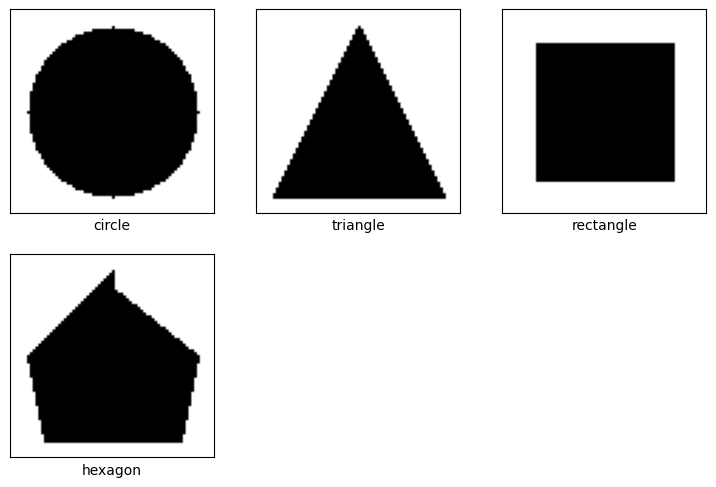

In [ ]:
shapes = {
    0: {'name': 'circle', 'file': 'circle_image.png'},
    1: {'name': 'triangle', 'file': 'triangle_image.png'},
    2: {'name': 'rectangle', 'file': 'rectangle_image.png'},
    3: {'name': 'hexagon', 'file': 'hexagon_image.png'}
}

plt.figure(figsize=(9, 9))

for i, (j, e) in enumerate(shapes.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join('shapes', e['file'])))
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.show()

### Create Examples for geometeric shapes

In [ ]:
for class_id, values in shapes.items():
    png_file = Image.open(os.path.join('shapes', values['file'])).convert('RGBA')
    png_file.load()
    new_file = Image.new("RGB", png_file.size, (255, 255, 255))
    new_file.paste(png_file, mask=png_file.split()[3])
    shapes[class_id]['image'] = new_file

In [ ]:
def create_example():
    class_id = np.random.randint(0, 4)
    image = np.ones((144,144,3)) * 255 # create white image of size 144X144
    row = np.random.randint(0,72)
    col = np.random.randint(0,72)
    image[row:row+72, col:col+72, :] = np.array(shapes[class_id]['image'])

    return image.astype('uint8'), class_id, (row+10)/144, (col+10)/144

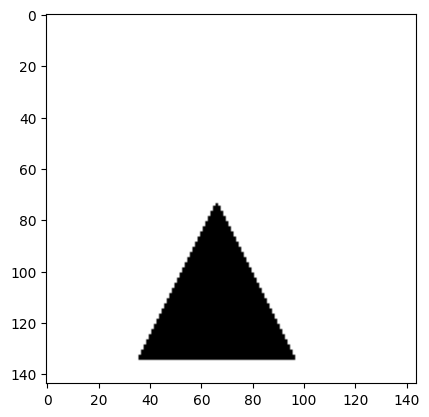

In [ ]:
image, class_id, row, col = create_example()
plt.imshow(image);

### Create Bounding Boxes

In [ ]:
def plot_bounding_box(image, gt_coords, pre_coords=[], norm=False):
    if norm:
        image*=255
        image = image.astype('uint8')
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)

    row, col = gt_coords
    row *=144
    col *=144

    draw.rectangle((col, row, col+52, row+52), outline='green', width=3)

    if len(pre_coords)==2:
        row, col = pre_coords
        row *=144
        col *=144

        draw.rectangle((col, row, col+52, row+52), outline='red', width=3)
    return image

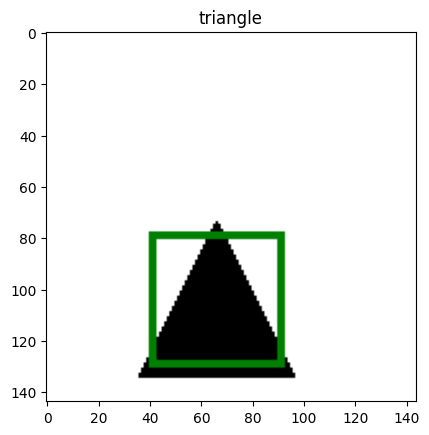

In [ ]:
image1 = plot_bounding_box(image, gt_coords=[row, col])
plt.imshow(image1)
plt.title(shapes[class_id]['name'])
plt.show()

### Data Generator

In [ ]:
def data_generator(batch_size=16):
    while True:
        x_batch = np.zeros((batch_size, 144, 144, 3))
        y_batch = np.zeros((batch_size, 4))
        bbox_batch = np.zeros((batch_size, 2))

        for i in range(0, batch_size):
            image, class_id, row, col = create_example()
            x_batch[i] = image/255.
            y_batch[i, class_id] = 1.0
            bbox_batch[i] = np.array([row, col])
        yield {'image':x_batch}, {'class_out':y_batch, 'box_out':bbox_batch}

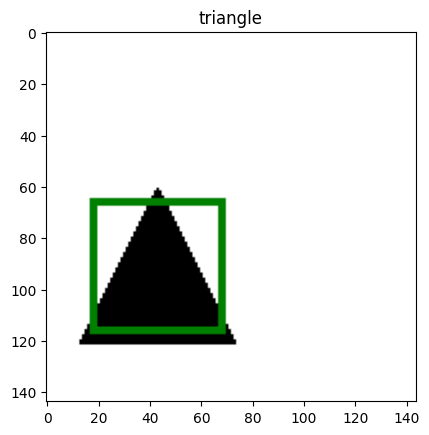

In [ ]:
example, label = next(data_generator(1))
image = example['image'][0]
class_id = np.argmax(label['class_out'][0])
coords = label['box_out'][0]

image1 = plot_bounding_box(image, coords, norm=True)
plt.imshow(image1)
plt.title(shapes[class_id]['name'])
plt.show()

# **Model Architecture**

In [ ]:
input_ = Input(shape=(144,144,3), name='image')

x = input_

for i in range(0,5):
    n_filters = 2**(4+i)
    x = Conv2D(n_filters, 3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)

# output classification
class_out = Dense(4, activation='softmax', name='class_out')(x)
# output bbox (Regression Output)
box_out = Dense(2, name='box_out')(x)

# Init model
model = tf.keras.models.Model(input_, [class_out, box_out])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 144, 144, 3)]        0         []                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 142, 142, 16)         448       ['image[0][0]']               
                                                                                                  
 batch_normalization_20 (Ba  (None, 142, 142, 16)         64        ['conv2d_20[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 max_pooling2d_20 (MaxPooli  (None, 71, 71, 16)           0         ['batch_normalization_20

###  Define Custom Metric: IoU for bounding boxes

In [ ]:
class IoU(tf.keras.metrics.Metric):
    def __init__(self, **kwargs):
        super(IoU, self).__init__(**kwargs)

        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        def get_box(y):
            rows, cols = y[:, 0], y[:, 1]
            rows, cols = rows*144, cols*144
            y1, y2 = rows, rows+52
            x1, x2 = cols, cols+52

            return x1, y1, x2, y2

        def get_area(x1, y1, x2, y2):
            return tf.math.abs(x2-x1) * tf.math.abs(y2-y1)

        gt_x1, gt_y1, gt_x2, gt_y2 = get_box(y_true)
        p_x1, p_y1, p_x2, p_y2 = get_box(y_pred)

        i_x1 = tf.maximum(gt_x1, p_x1)
        i_y1 = tf.maximum(gt_y1, p_y1)
        i_x2 = tf.maximum(gt_x2, p_x2)
        i_y2 = tf.maximum(gt_y2, p_y2)

        i_area = get_area(i_x1, i_y1, i_x2, i_y2)
        u_area = get_area(gt_x1, gt_y1, gt_x2, gt_y2) + get_area(p_x1, p_y1, p_x2, p_y2) - i_area

        iou = tf.math.divide(i_area, u_area)

        self.num_ex.assign_add(1)
        self.total_iou.assign_add(tf.reduce_mean(iou))
        self.iou = tf.math.divide(self.total_iou, self.num_ex)

    def result(self):
        return self.iou

    def reset_state(self):
        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')


### Compile the Model

In [ ]:
model.compile(
    loss={'class_out':'categorical_crossentropy',
          'box_out':'mse'},
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics = {
        'class_out':'accuracy',
        'box_out':IoU(name='iou')
    }

)

### Custom Callback: Model Testing

In [ ]:
def test_model(model, test_datagen):
    example, label = next(test_datagen)
    x = example['image']
    y = label['class_out']
    box = label['box_out']

    pred_y, pred_box = model.predict(x)

    pred_coords = pred_box[0]
    gt_coords = box[0]

    pred_class = np.argmax(pred_y[0])
    image = x[0]

    gt = shapes[np.argmax(y[0])]['name']
    pred_class_name = shapes[pred_class]['name']

    image = plot_bounding_box(image, gt_coords, pred_coords, norm=True)
    color='green' if gt==pred_class_name else 'red'

    plt.imshow(image)
    plt.xlabel(f'Pred: {pred_class_name}', color=color)
    plt.xlabel(f'GT: {gt}', color=color)
    plt.xticks([])
    plt.yticks([])


In [ ]:
def test(model):
    test_datagen = data_generator(1)

    plt.figure(figsize=(16,4))

    for i in range(0,6):
        plt.subplot(1,6,i+1)
        test_model(model, test_datagen)
    plt.show()

1/1 [==============================] - 0s 27ms/step


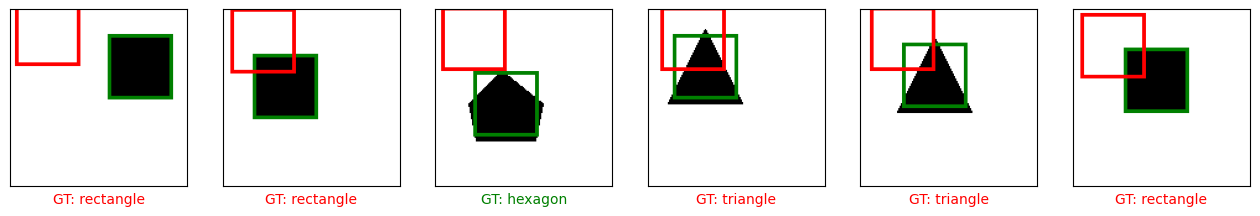

In [ ]:
test(model)

In [ ]:
class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)


# **Model Training**

Epoch 1/20
1/1 [==============================] - 0s 17ms/step


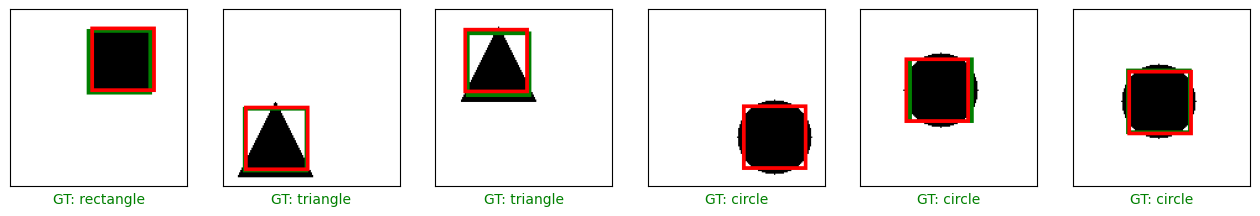

500/500 [==============================] - 8s 16ms/step - loss: 5.2932e-04 - class_out_loss: 5.4930e-05 - box_out_loss: 4.7439e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.0000e+00 - lr: 1.6000e-06
Epoch 2/20
1/1 [==============================] - 0s 17ms/step


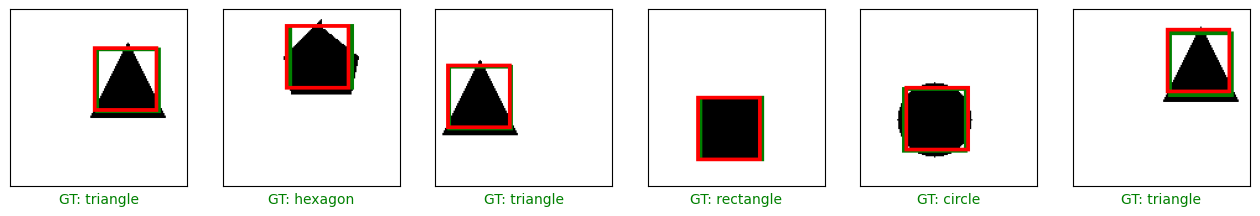

500/500 [==============================] - 9s 18ms/step - loss: 5.0397e-04 - class_out_loss: 3.9283e-05 - box_out_loss: 4.6469e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.0000e+00 - lr: 1.6000e-06
Epoch 3/20
1/1 [==============================] - 0s 18ms/step


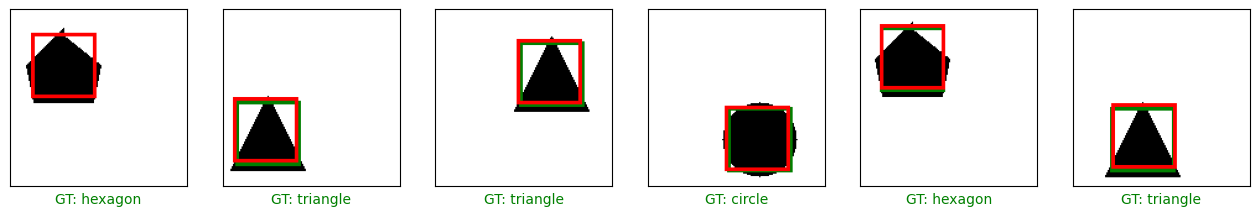

500/500 [==============================] - 10s 19ms/step - loss: 5.1164e-04 - class_out_loss: 5.0391e-05 - box_out_loss: 4.6125e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.0000e+00 - lr: 1.6000e-06
Epoch 4/20
1/1 [==============================] - 0s 18ms/step


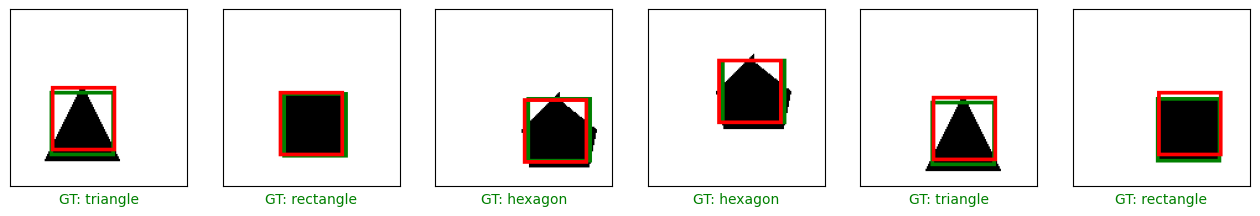

500/500 [==============================] - 8s 16ms/step - loss: 4.9473e-04 - class_out_loss: 4.4333e-05 - box_out_loss: 4.5040e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.0000e+00 - lr: 1.6000e-06


In [ ]:
def lr_schedule(epoch, lr):
    if (epoch+1) %5==0:
        lr *=0.2
    return max(lr, 3e-7)

_ = model.fit(
    data_generator(),
    epochs=20,
    steps_per_epoch = 500,
    callbacks=[
        ShowTestImages(),
        tf.keras.callbacks.EarlyStopping(monitor='box_out_iou', patience=3),
        tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ]
)

### **Save Model**

In [ ]:
# Save the trained model
model.save('trained_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
